<a href="https://colab.research.google.com/github/jiyoonkim7/project2/blob/main/model_nn_car.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [87]:

import torch
from torch.utils.data import Dataset, DataLoader, random_split,TensorDataset

In [88]:
# Load the data using numpy
data = np.loadtxt("/Lidar.samples", dtype=np.double)

In [89]:
# Get cpu, gpu or mps device for training.
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

# Saving the read out data in numpy arrays
dataY = data[:, -1:] 
dataX = data[:,:-1]

# Transforming numpy arrays to tensors
dataX_tensor = torch.tensor(dataX)
dataY_tensor = torch.tensor(dataY)

# Combine input and output tensors into a tensordataset
dataset = TensorDataset(dataX_tensor, dataY_tensor)

# Define the size of your training and testing subsets
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size

# Manual seed for reproducible results
train_dataset, test_dataset = random_split(dataset, [train_size, test_size], torch.Generator().manual_seed(42))

# Use dataloader for batching and iterating
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=True)

Using cuda device


In [90]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

In [91]:
# Define the neural network model


from torch import nn
class NeuralNetwork(nn.Module): #from torch import nn
    def __init__(self):
        super().__init__()
        self.linear_1hiddenlayer = nn.Sequential(
            nn.Linear(16, 64), 
            nn.ReLU(),
            nn.Dropout(p=0.2),
            nn.Linear(64, 32),
            nn.SiLU(),
            nn.Dropout(p=0.2),
            nn.Linear(32,1)
       
        )

    def forward(self, x):
        logits = self.linear_1hiddenlayer(x)
        return logits

# Load neural network
model = NeuralNetwork().double().to(device) #keep it float64 and move model to GPU 

# Choosing loss function and optimizer
loss_fn = nn.MSELoss() 
optimizer = torch.optim.Adagrad(model.parameters(), lr=1e-1) # try Adam  or Adagrad

In [92]:
test_tensor = torch.tensor([1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16]).to('cuda').double()
print(test_tensor.shape)
print(test_tensor.dtype)



torch.Size([16])
torch.float64


In [ ]:
model(test_tensor).to('cuda')

In [93]:
# Train the model 
epochs = 500
epochresults = []
for epoch in range(epochs):
  running_loss = 0.0
  for i, (inputs, labels) in enumerate(train_dataloader):
    
    #---load data into GPU----
    inputs = inputs.to('cuda')
    labels = labels.to('cuda')
    #-------------------------
    
    outputs = model(inputs)  # forward propagation
    #print(outputs)
    loss = loss_fn(outputs, labels)    
    # to remove previous epoch gradients
    optimizer.zero_grad()    # set optimizer to zero grad
    loss.backward()    
    optimizer.step()
    running_loss += loss.item()  

  epoch_loss = running_loss / len(train_dataloader)
  epochresults.append(epoch_loss)
  print(f'Epochs:{epoch + 1:5d} | ' \
        f'Loss: {epoch_loss:.10f}')

#something is wrong when increasing epoch 100->1000 the time for each 100 epochs goes up xD

Epochs:    1 | Loss: 126.2509399892
Epochs:    2 | Loss: 77.9623798184
Epochs:    3 | Loss: 71.4764260178
Epochs:    4 | Loss: 67.1823460972
Epochs:    5 | Loss: 64.6868476827
Epochs:    6 | Loss: 63.8482754002
Epochs:    7 | Loss: 62.3109187178
Epochs:    8 | Loss: 61.7688086314
Epochs:    9 | Loss: 60.1754210824
Epochs:   10 | Loss: 57.6326739077
Epochs:   11 | Loss: 57.1469437321
Epochs:   12 | Loss: 57.1541345789
Epochs:   13 | Loss: 55.8873729436
Epochs:   14 | Loss: 55.2504056908
Epochs:   15 | Loss: 55.0573333557
Epochs:   16 | Loss: 53.9278258956
Epochs:   17 | Loss: 53.2399212215
Epochs:   18 | Loss: 53.4735071688
Epochs:   19 | Loss: 51.7153018290
Epochs:   20 | Loss: 51.7854926874
Epochs:   21 | Loss: 51.5772079959
Epochs:   22 | Loss: 51.5336735828
Epochs:   23 | Loss: 50.4439467946
Epochs:   24 | Loss: 51.1205672155
Epochs:   25 | Loss: 50.5216196172
Epochs:   26 | Loss: 50.0588870534
Epochs:   27 | Loss: 49.4910800245
Epochs:   28 | Loss: 48.4528039205
Epochs:   29 | Loss

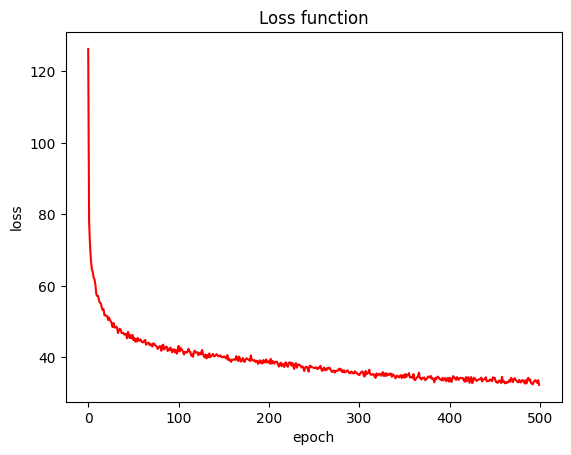

In [94]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
ax.set(xlabel='epoch', ylabel='loss', title="Loss function")

plt.plot(epochresults, 'red')
plt.show()

In [95]:
# Evaluate the model on the test set
model.eval()  # Set the model to evaluation mode

test_loss = 0.0

with torch.no_grad():  # Disable gradient tracking
    for inputs, labels in test_dataloader:

        #---load data into GPU----
        inputs = inputs.to('cuda')
        labels = labels.to('cuda')
        #-------------------------
        
        outputs = model(inputs)
        test_loss += loss_fn(outputs, labels).item()

test_loss /= len(test_dataloader)
print(f'Test set loss: {test_loss:.4f}')


Test set loss: 24.7904


In [96]:
# # save the trained model
# PATH = 'model3.pth'
# torch.save(model.state_dict(), PATH)